In [33]:
import graphviz as gv
from IPython.display import Image
from pydantic.dataclasses import dataclass
from dataclasses import field


In [34]:
def display_g(g):
    display(Image(filename=g.render(format="png")))

In [38]:
class Visitor:
    def visit(self, op: "Op"): ...
class Node:
    def accept(self, v: Visitor): ...

@dataclass(kw_only=True)
class Op(Node):
    catch: dict[str, "Action"]|None = None

    def accept(self, v: Visitor):
        v.visit(self)

@dataclass(kw_only=True)
class Action(Op):
    name: str

@dataclass(kw_only=True)
class Object(Op):
    name: str
    cls: str

    def accept(self, v: Visitor):
        v.visit(self)

@dataclass(kw_only=True)
class Function(Op):
    name: str
    ops: list[Op]

    def accept(self, v: Visitor):
        v.visit(self)
        for op in self.ops:
            op.accept(v)


program = Function(name="Task", ops=[Function(name="Drive", ops=[Object(name="engine", cls="Engine")]), Action(name="Foo"), Action(name="Bar")],catch={"_": Action(name="turn_on_error")})


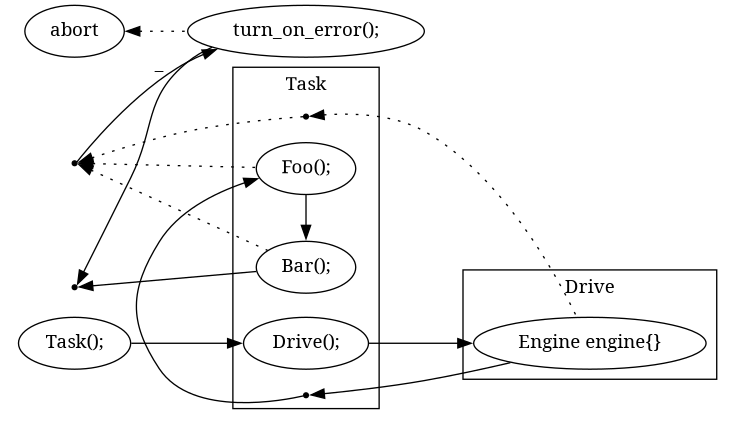

digraph {
	rankdir=LR
	err [label=abort]
	137800158188256 [label="Task();"]
	err_137800158188256 [shape=point]
	137800158188256 -> err_137800158188256 [constraint=false style=invis]
	137800268562848 -> err_137800268562848 [constraint=false style=invis]
	err_137800268562848 -> 137800168448144 [dir=back style=dotted]
	subgraph cluster_137800268562848 {
		label=Drive
		137800168448144 [label="Engine engine{}"]
	}
	err_137800268562848 -> ret_137800268562848 [constraint=false style=invis]
	ret_137800268562848 -> 137800168448144 [dir=back]
	err_137800158188256 -> err_137800268562848 [dir=back style=dotted]
	137800158188256 -> 137800268562848
	err_137800158188256 -> 137800158193008 [dir=back style=dotted]
	err_137800158188256 -> 137800158196416 [dir=back style=dotted]
	subgraph cluster_137800158188256 {
		label=Task
		137800268562848 [label="Drive();"]
		err_137800268562848 [shape=point]
		137800268562848 -> 137800168448144
		ret_137800268562848 [shape=point]
		137800158193008 [label="Foo();"

In [53]:
def key(op: Op, extra:str|None=None):
    k = f"{id(op)}"
    if extra: k = extra + "_" + k
    return k

class Cxx:
    def __init__(self, op: Op):
        self.root = gv.Digraph()
        self.root.attr(rankdir="LR")
        # self.root.node(curr:="start", "start")
        self.root.node(err:="err", "abort")
        first, last = self.visit_Op(op, self.root, err)
        # self.root.edge(curr, curr)
        # self.root.node(end:="end", "end")
        # self.root.edge(last, end)
   
    def visit_Op(self, op: Op, g: gv.Digraph, err:str) -> tuple[str, str]:
        match op:
            case Function():
                g.node(curr:=key(op), f"{op.name}();")
                # self.root.edge(last, curr)
                # last = curr
                g.node(cerr:=key(op, "err"), shape="point")
                # self.root.edge(curr, cerr, style="invis")
                self.root.edge(curr, cerr, constraint="false", style="invis")
                
                with self.root.subgraph(name=key(op, "cluster")) as cg:
                    cg: gv.Digraph
                    cg.attr(label=op.name)
                    for cop_i, cop in enumerate(op.ops):
                        first, last = self.visit_Op(cop, cg, cerr)
                        if cop_i == 0:
                            g.edge(curr, first)
                        if cop_i != 0:
                            cg.edge(prev, first, constraint="false")
                        prev = last
                
                g.node(ret:=key(op, "ret"), shape="point")
                self.root.edge(cerr, ret, constraint="false", style="invis")
                self.root.edge(ret, last, dir="back")
            case Object():
                g.node(curr:=key(op), f"{op.cls} {op.name}{{}}")
                cerr = ret = curr
            case Action():
                g.node(curr:=key(op), f"{op.name}();")
                cerr = ret = curr
            case _:
                raise NotImplementedError()
        
        if op.catch is not None:
            for e, eop in op.catch.items():
                first, last = self.visit_Op(eop, g, err)
                self.root.edge(cerr, first, e, constraint="false")
                self.root.edge(last, ret, constraint="false")
        
        if op.catch is None or "_" not in op.catch:
            self.root.edge(err, cerr, dir="back", style="dotted")

        return curr, ret

cxx = Cxx(program)
display_g(cxx.root)
print(cxx.root.source)


In [37]:

g = gv.Digraph()
self.root.edge("foo", "bar", weight="1")
self.root.edge("foo", "baaz", weight="1")
self.root.edge("baaz", "baaz1", weight="1")
self.root.edge("baaz1", "foo", constraint="false")

display_g(g)

NameError: name 'self' is not defined